<a href="https://colab.research.google.com/github/cs-iuu/ocr-2025-fall-cv/blob/main/notebooks/15.1.stereo_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stereo Vision Coding Practice
Updated to fix warpPerspective size error.

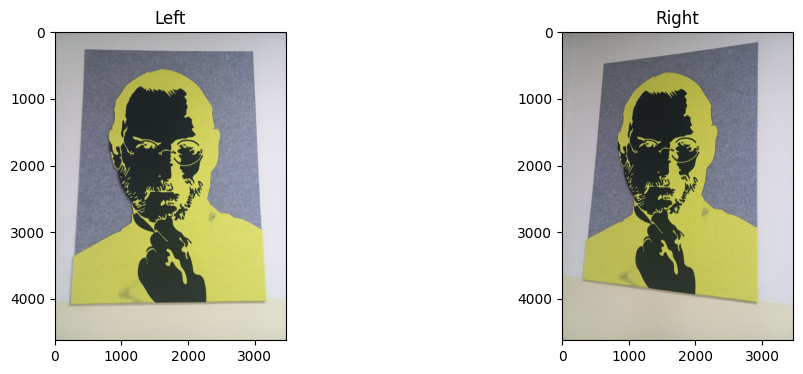

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load sample stereo pair (you may replace these with your own)
# left_img = cv2.imread('bike-left.png')
# right_img = cv2.imread('bike-right.png')
left_img = cv2.imread('left.jpg')
right_img = cv2.imread('right.jpg')

if left_img is None or right_img is None:
    print("Please upload left.png and right.png before running.")

# Convert BGR → RGB
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(left_img); plt.title("Left")
plt.subplot(1,2,2); plt.imshow(right_img); plt.title("Right")
plt.show()

## Fundamental Matrix Estimation

In [13]:
# Detect keypoints
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(left_img, None)
kp2, des2 = sift.detectAndCompute(right_img, None)

# Match keypoints
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good = []
pts1 = []
pts2 = []

for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

# Estimate Fundamental Matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
print("Fundamental Matrix F:\n", F)

Fundamental Matrix F:
 [[ 2.69689947e-07 -2.91869871e-06  2.23216319e-03]
 [ 2.85711950e-06 -1.51990044e-07 -5.45338157e-03]
 [-3.19759493e-03  5.56582700e-03  1.00000000e+00]]


## Stereo Rectification (Uncalibrated)

In [14]:
# Stereo rectification (uncalibrated)
rectify_result = cv2.stereoRectifyUncalibrated(
    pts1, pts2, F, imgSize=(left_img.shape[1], left_img.shape[0])
)

# Handle different OpenCV return formats
if len(rectify_result) == 3:
    ret, h1, h2 = rectify_result
else:
    h1, h2 = rectify_result

# Image size
h, w = left_img.shape[:2]

# Warp with correct size
left_rectified = cv2.warpPerspective(left_img, h1, (w, h))
right_rectified = cv2.warpPerspective(right_img, h2, (w, h))


## Disparity and Depth Map (SGBM)

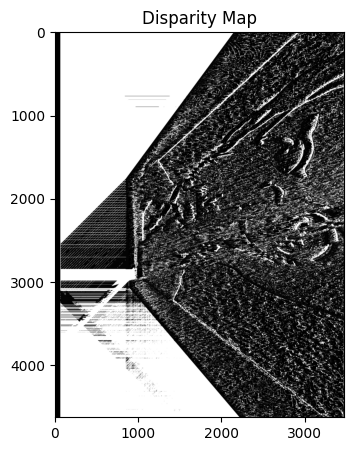

In [15]:
# Convert to grayscale
left_gray = cv2.cvtColor(left_rectified, cv2.COLOR_RGB2GRAY)
right_gray = cv2.cvtColor(right_rectified, cv2.COLOR_RGB2GRAY)

# Create SGBM matcher
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=64,
    blockSize=9
)

disp = stereo.compute(left_gray, right_gray)
disp_vis = cv2.normalize(disp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.figure(figsize=(8,5))
plt.imshow(disp_vis, cmap='gray')
plt.title("Disparity Map")
plt.show()

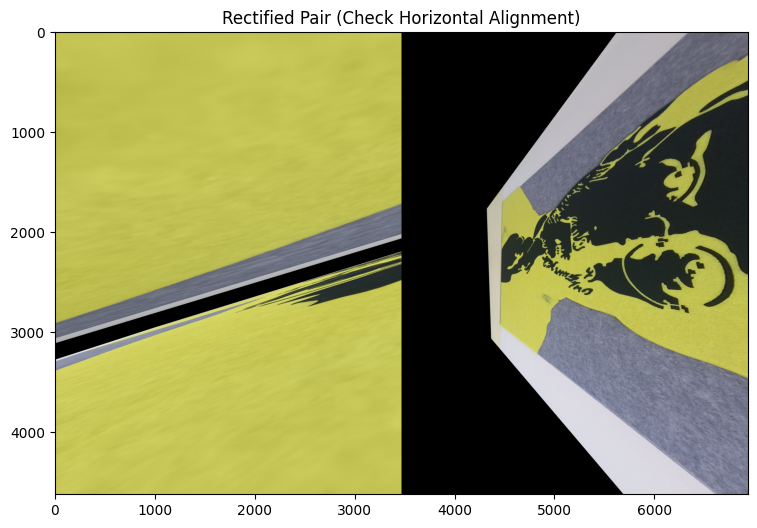

In [16]:
plt.figure(figsize=(15,6))
plt.imshow(np.hstack((left_rectified, right_rectified)))
plt.title("Rectified Pair (Check Horizontal Alignment)")
plt.show()
